In [ ]:
from numpy import random
import pandas as pd
df=pd.read_csv("/content/spotify_data.csv")
df=df.sample(n=5000,random_state=42).reset_index(drop=True)
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.910,1977,0.500,['Idris Muhammad'],0.894,273067,0.5210,0,0KdzyvsBqX1HV3uLxGm2JV,0.772,4,0.068,-7.048,1,Camby Bolongo,34,1977,0.0847,126.805
1,0.583,1976,0.930,['Stan Getz'],0.585,182200,0.2720,0,1f4eO5waC6glPLXUhYKLm2,0.115,11,0.128,-16.693,0,Just One of Those Things,26,1976,0.0802,90.104
2,0.647,1994,0.157,"['Warren G', 'The Twinz']",0.878,179933,0.5200,1,1X07ZfF5KQt8dyJ5kAkVAQ,0.000,7,0.173,-12.609,1,Recognize,38,1994-06-07,0.4030,90.744
3,0.196,1957,0.937,['Red Garland Quintet'],0.463,925947,0.2870,0,5wmMDeM4qvLfwqLa2cvoks,0.837,0,0.112,-11.758,0,Soul Junction,13,1957,0.0363,186.764
4,0.422,1921,0.995,['Ignacio Corsini'],0.648,154240,0.0995,0,0SK1upzAP6NvIgF0uGh6z2,0.846,11,0.112,-22.429,1,Flor Marchita - Remasterizado,0,1921-03-20,0.1050,71.978


In [ ]:
from sklearn.preprocessing import StandardScaler
numerical_feature=[
    "valence","danceability","energy","acousticness","instrumentalness","liveness","loudness","speechiness","tempo"
]

scaler=StandardScaler()
df_scaled=scaler.fit_transform(df[numerical_feature])
df_scaled=pd.DataFrame(df_scaled,columns=numerical_feature)
df_scaled.head()

,valence,danceability,energy,acousticness,instrumentalness,liveness,loudness,speechiness,tempo
0,1.473178,2.032267,0.142150,-0.005840,1.916073,-0.783298,0.748488,-0.107375,0.310507
1,0.226049,0.276101,-0.771789,1.126217,-0.171477,-0.446557,-0.891331,-0.133457,-0.886487
2,0.470135,1.941333,0.138480,-0.908852,-0.536877,-0.194001,-0.196979,1.737477,-0.865614
3,-1.249911,-0.417272,-0.716732,1.144646,2.122604,-0.536354,-0.052294,-0.387900,2.266056
4,-0.387981,0.634154,-1.404939,1.297342,2.151200,-0.536354,-1.866551,0.010283,-1.477663


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data= train_test_split(df_scaled,test_size=0.2,random_state=42)

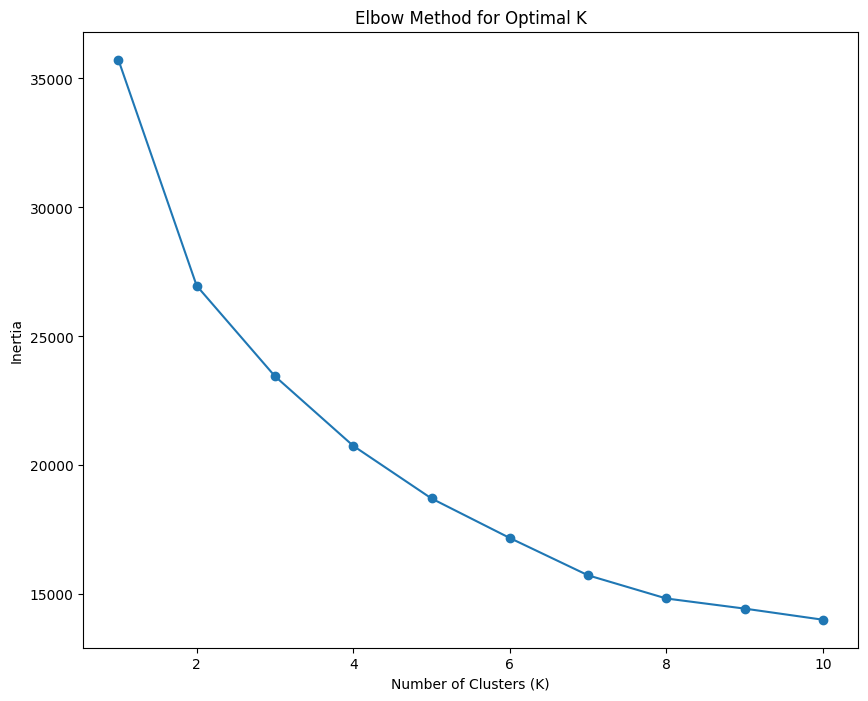

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_value = range(1, 11)

for k in k_value:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

# 📊 Plot AFTER the loop
plt.figure(figsize=(10, 8))
plt.plot(k_value, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


In [ ]:
optimal_k=5
kmeans=KMeans(n_clusters=optimal_k,random_state=42)
df["cluster"]=kmeans.fit_predict(df_scaled)

In [ ]:
df['cluster'].value_counts()

,count
cluster,
1,1567
2,1310
0,1201
3,721
4,201


In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
reduced_data=pca.fit_transform(df_scaled)

In [ ]:
def recommend_songs(song_name, df, num_recommendations=5):
    if song_name not in df["name"].values:
        return None

    song_cluster = df[df["name"] == song_name]["cluster"].values[0]
    same_cluster_songs = df[df["cluster"] == song_cluster].reset_index(drop=True)

    song_index = same_cluster_songs[same_cluster_songs["name"] == song_name].index[0]
    cluster_features = same_cluster_songs[numerical_feature].values

    similarity = cosine_similarity(cluster_features, cluster_features)

    similar_songs = np.argsort(similarity[song_index])[::-1][1:num_recommendations+1]
    return same_cluster_songs.iloc[similar_songs][["name", "year", "artists"]]


In [ ]:
input_song = "Camby Bolongo"

if input_song in df["name"].values:
    recommended_songs = recommend_songs(input_song, df, num_recommendations=5)
    print(f"Recommended songs for '{input_song}':")
    print(recommended_songs)
else:
    print(f"Song '{input_song}' not found in the dataset.")


Recommended songs for 'Camby Bolongo':
                                               name  year  \
766                                       Tiger Rag  1970   
401                   Scalextric - Dani Sbert Remix  1950   
868                                   Disco Science  2000   
747  Gloria de Guapo - Instrumental (Remasterizado)  1931   
438                                          Zambia  1954   

                                       artists  
766        ['Django Reinhardt', 'Andre Ekyan']  
401  ['Pig&Dan', 'Alberto Ruiz', 'Dani Sbert']  
868                                ['Mirwais']  
747                       ['Francisco Canaro']  
438              ['Machito & His Afro Cubans']  


In [ ]:
df.to_csv("clustered_data.csv")